

# Tree-LSTM in DGL

**Author**: Zihao Ye, Qipeng Guo, [Minjie Wang](https://jermainewang.github.io/), [Jake Zhao](https://cs.nyu.edu/~jakezhao/), Zheng Zhang

<div class="alert alert-danger"><h4>Warning</h4><p>The tutorial aims at gaining insights into the paper, with code as a mean
    of explanation. The implementation thus is NOT optimized for running
    efficiency. For recommended implementation, please refer to the [official
    examples](https://github.com/dmlc/dgl/tree/master/examples).</p></div>


In [1]:
import os

In this tutorial, you learn to use Tree-LSTM networks for sentiment analysis.
The Tree-LSTM is a generalization of long short-term memory (LSTM) networks to tree-structured network topologies.

The Tree-LSTM structure was first introduced by Kai et. al in an ACL 2015
paper: [Improved Semantic Representations From Tree-Structured Long
Short-Term Memory Networks](https://arxiv.org/pdf/1503.00075.pdf)_.
The core idea is to introduce syntactic information for language tasks by
extending the chain-structured LSTM to a tree-structured LSTM. The dependency
tree and constituency tree techniques are leveraged to obtain a ''latent tree''.

The challenge in training Tree-LSTMs is batching --- a standard
technique in machine learning to accelerate optimization. However, since trees
generally have different shapes by nature, parallization is non-trivial.
DGL offers an alternative. Pool all the trees into one single graph then
induce the message passing over them, guided by the structure of each tree.

## The task and the dataset

The steps here use the
[Stanford Sentiment Treebank](https://nlp.stanford.edu/sentiment/)_ in
``dgl.data``. The dataset provides a fine-grained, tree-level sentiment
annotation. There are five classes: Very negative, negative, neutral, positive, and
very positive, which indicate the sentiment in the current subtree. Non-leaf
nodes in a constituency tree do not contain words, so use a special
``PAD_WORD`` token to denote them. During training and inference
their embeddings would be masked to all-zero.

.. figure:: https://i.loli.net/2018/11/08/5be3d4bfe031b.png
   :alt:

The figure displays one sample of the SST dataset, which is a
constituency parse tree with their nodes labeled with sentiment. To
speed up things, build a tiny set with five sentences and take a look
at the first one.




In [2]:
from collections import namedtuple

os.environ["DGLBACKEND"] = "pytorch"
import dgl
from dgl.data.tree import SSTDataset


SSTBatch = namedtuple("SSTBatch", ["graph", "mask", "wordid", "label"])

# Each sample in the dataset is a constituency tree. The leaf nodes
# represent words. The word is an int value stored in the "x" field.
# The non-leaf nodes have a special word PAD_WORD. The sentiment
# label is stored in the "y" feature field.
trainset = SSTDataset(mode="tiny")  # the "tiny" set has only five trees
tiny_sst = [tr for tr in trainset]
num_vocabs = trainset.vocab_size
num_classes = trainset.num_classes

vocab = trainset.vocab  # vocabulary dict: key -> id
inv_vocab = {
    v: k for k, v in vocab.items()
}  # inverted vocabulary dict: id -> word

a_tree = tiny_sst[0]
for token in a_tree.ndata["x"].tolist():
    if token != trainset.PAD_WORD:
        print(inv_vocab[token], end=" ")
import matplotlib.pyplot as plt

the rock is destined to be the 21st century 's new `` conan '' and that he 's going to make a splash even greater than arnold schwarzenegger , jean-claud van damme or steven segal . 

## Step 1: Batching

Add all the trees to one graph, using
the :func:`~dgl.batched_graph.batch` API.




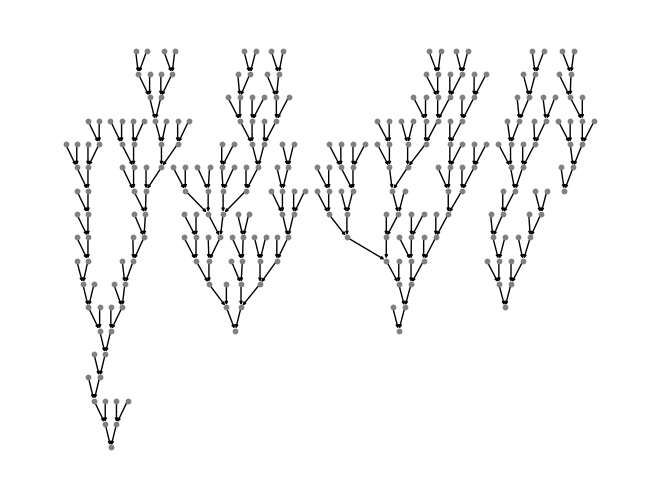

In [3]:
import networkx as nx

graph = dgl.batch(tiny_sst)


def plot_tree(g):
    # this plot requires pygraphviz package
    pos = nx.nx_agraph.graphviz_layout(g, prog="dot")
    nx.draw(
        g,
        pos,
        with_labels=False,
        node_size=10,
        node_color=[[0.5, 0.5, 0.5]],
        arrowsize=4,
    )
    plt.show()


plot_tree(graph.to_networkx())

You can read more about the definition of :func:`~dgl.batch`, or
skip ahead to the next step:
<div class="alert alert-info"><h4>Note</h4><p>**Definition**: :func:`~dgl.batch` unions a list of $B$
     :class:`~dgl.DGLGraph`\ s and returns a :class:`~dgl.DGLGraph` of batch
     size $B$.

   - The union includes all the nodes,
     edges, and their features. The order of nodes, edges, and features are
     preserved.

       - Given that you have $V_i$ nodes for graph
         $\mathcal{G}_i$, the node ID $j$ in graph
         $\mathcal{G}_i$ correspond to node ID
         $j + \sum_{k=1}^{i-1} V_k$ in the batched graph.

       - Therefore, performing feature transformation and message passing on
         the batched graph is equivalent to doing those
         on all ``DGLGraph`` constituents in parallel.

   - Duplicate references to the same graph are
     treated as deep copies; the nodes, edges, and features are duplicated,
     and mutation on one reference does not affect the other.
   - The batched graph keeps track of the meta
     information of the constituents so it can be
     :func:`~dgl.batched_graph.unbatch`\ ed to list of ``DGLGraph``\ s.</p></div>

## Step 2: Tree-LSTM cell with message-passing APIs

Researchers have proposed two types of Tree-LSTMs: Child-Sum
Tree-LSTMs, and $N$-ary Tree-LSTMs. In this tutorial you focus
on applying *Binary* Tree-LSTM to binarized constituency trees. This
application is also known as *Constituency Tree-LSTM*. Use PyTorch
as a backend framework to set up the network.

In `N`-ary Tree-LSTM, each unit at node $j$ maintains a hidden
representation $h_j$ and a memory cell $c_j$. The unit
$j$ takes the input vector $x_j$ and the hidden
representations of the child units: $h_{jl}, 1\leq l\leq N$ as
input, then update its new hidden representation $h_j$ and memory
cell $c_j$ by:

\begin{align}i_j & = & \sigma\left(W^{(i)}x_j + \sum_{l=1}^{N}U^{(i)}_l h_{jl} + b^{(i)}\right),  & (1)\\
   f_{jk} & = & \sigma\left(W^{(f)}x_j + \sum_{l=1}^{N}U_{kl}^{(f)} h_{jl} + b^{(f)} \right), &  (2)\\
   o_j & = & \sigma\left(W^{(o)}x_j + \sum_{l=1}^{N}U_{l}^{(o)} h_{jl} + b^{(o)} \right), & (3)  \\
   u_j & = & \textrm{tanh}\left(W^{(u)}x_j + \sum_{l=1}^{N} U_l^{(u)}h_{jl} + b^{(u)} \right), & (4)\\
   c_j & = & i_j \odot u_j + \sum_{l=1}^{N} f_{jl} \odot c_{jl}, &(5) \\
   h_j & = & o_j \cdot \textrm{tanh}(c_j), &(6)  \\\end{align}

It can be decomposed into three phases: ``message_func``,
``reduce_func`` and ``apply_node_func``.

<div class="alert alert-info"><h4>Note</h4><p>``apply_node_func`` is a new node UDF that has not been introduced before. In
   ``apply_node_func``, a user specifies what to do with node features,
   without considering edge features and messages. In a Tree-LSTM case,
   ``apply_node_func`` is a must, since there exists (leaf) nodes with
   $0$ incoming edges, which would not be updated with
   ``reduce_func``.</p></div>




In [4]:
import torch as th
import torch.nn as nn


class TreeLSTMCell(nn.Module):
    def __init__(self, x_size, h_size):
        super(TreeLSTMCell, self).__init__()
        self.W_iou = nn.Linear(x_size, 3 * h_size, bias=False)
        self.U_iou = nn.Linear(2 * h_size, 3 * h_size, bias=False)
        self.b_iou = nn.Parameter(th.zeros(1, 3 * h_size))
        self.U_f = nn.Linear(2 * h_size, 2 * h_size)

    def message_func(self, edges):
        return {"h": edges.src["h"], "c": edges.src["c"]}

    def reduce_func(self, nodes):
        # concatenate h_jl for equation (1), (2), (3), (4)
        h_cat = nodes.mailbox["h"].view(nodes.mailbox["h"].size(0), -1)
        # equation (2)
        f = th.sigmoid(self.U_f(h_cat)).view(*nodes.mailbox["h"].size())
        # second term of equation (5)
        c = th.sum(f * nodes.mailbox["c"], 1)
        return {"iou": self.U_iou(h_cat), "c": c}

    def apply_node_func(self, nodes):
        # equation (1), (3), (4)
        iou = nodes.data["iou"] + self.b_iou
        i, o, u = th.chunk(iou, 3, 1)
        i, o, u = th.sigmoid(i), th.sigmoid(o), th.tanh(u)
        # equation (5)
        c = i * u + nodes.data["c"]
        # equation (6)
        h = o * th.tanh(c)
        return {"h": h, "c": c}

## Step 3: Define traversal

After you define the message-passing functions, induce the
right order to trigger them. This is a significant departure from models
such as GCN, where all nodes are pulling messages from upstream ones
*simultaneously*.

In the case of Tree-LSTM, messages start from leaves of the tree, and
propagate/processed upwards until they reach the roots. A visualization
is as follows:

.. figure:: https://i.loli.net/2018/11/09/5be4b5d2df54d.gif
   :alt:

DGL defines a generator to perform the topological sort, each item is a
tensor recording the nodes from bottom level to the roots. One can
appreciate the degree of parallelism by inspecting the difference of the
followings:




In [5]:
# to heterogenous graph
trv_a_tree = dgl.graph(a_tree.edges())
print("Traversing one tree:")
print(dgl.topological_nodes_generator(trv_a_tree))

# to heterogenous graph
trv_graph = dgl.graph(graph.edges())
print("Traversing many trees at the same time:")
print(dgl.topological_nodes_generator(trv_graph))

Traversing one tree:
(tensor([ 2,  3,  6,  8, 13, 15, 17, 19, 22, 23, 25, 27, 28, 29, 30, 32, 34, 36,
        38, 40, 43, 46, 47, 49, 50, 52, 58, 59, 60, 62, 64, 65, 66, 68, 69, 70]), tensor([ 1, 21, 26, 45, 48, 57, 63, 67]), tensor([24, 44, 56, 61]), tensor([20, 42, 55]), tensor([18, 54]), tensor([16, 53]), tensor([14, 51]), tensor([12, 41]), tensor([11, 39]), tensor([10, 37]), tensor([35]), tensor([33]), tensor([31]), tensor([9]), tensor([7]), tensor([5]), tensor([4]), tensor([0]))
Traversing many trees at the same time:
(tensor([  2,   3,   6,   8,  13,  15,  17,  19,  22,  23,  25,  27,  28,  29,
         30,  32,  34,  36,  38,  40,  43,  46,  47,  49,  50,  52,  58,  59,
         60,  62,  64,  65,  66,  68,  69,  70,  74,  76,  78,  79,  82,  83,
         85,  88,  90,  92,  93,  95,  96, 100, 102, 103, 105, 109, 110, 112,
        113, 117, 118, 119, 121, 125, 127, 129, 130, 132, 133, 135, 138, 140,
        141, 142, 143, 150, 152, 153, 155, 158, 159, 161, 162, 164, 168, 170,
  

Call :meth:`~dgl.DGLGraph.prop_nodes` to trigger the message passing:



In [6]:
import dgl.function as fn
import torch as th

trv_graph.ndata["a"] = th.ones(graph.num_nodes(), 1)
traversal_order = dgl.topological_nodes_generator(trv_graph)
trv_graph.prop_nodes(
    traversal_order,
    message_func=fn.copy_u("a", "a"),
    reduce_func=fn.sum("a", "a"),
)

# the following is a syntax sugar that does the same
# dgl.prop_nodes_topo(graph)

<div class="alert alert-info"><h4>Note</h4><p>Before you call :meth:`~dgl.DGLGraph.prop_nodes`, specify a
   `message_func` and `reduce_func` in advance. In the example, you can see built-in
   copy-from-source and sum functions as message functions, and a reduce
   function for demonstration.</p></div>

## Putting it together

Here is the complete code that specifies the ``Tree-LSTM`` class.




In [7]:
class TreeLSTM(nn.Module):
    def __init__(
        self,
        num_vocabs,
        x_size,
        h_size,
        num_classes,
        dropout,
        pretrained_emb=None,
    ):
        super(TreeLSTM, self).__init__()
        self.x_size = x_size
        self.embedding = nn.Embedding(num_vocabs, x_size)
        if pretrained_emb is not None:
            print("Using glove")
            self.embedding.weight.data.copy_(pretrained_emb)
            self.embedding.weight.requires_grad = True
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(h_size, num_classes)
        self.cell = TreeLSTMCell(x_size, h_size)

    def forward(self, batch, h, c):
        """Compute tree-lstm prediction given a batch.

        Parameters
        ----------
        batch : dgl.data.SSTBatch
            The data batch.
        h : Tensor
            Initial hidden state.
        c : Tensor
            Initial cell state.

        Returns
        -------
        logits : Tensor
            The prediction of each node.
        """
        g = batch.graph
        # to heterogenous graph
        g = dgl.graph(g.edges())
        # feed embedding
        embeds = self.embedding(batch.wordid * batch.mask)
        g.ndata["iou"] = self.cell.W_iou(
            self.dropout(embeds)
        ) * batch.mask.float().unsqueeze(-1)
        g.ndata["h"] = h
        g.ndata["c"] = c
        # propagate
        dgl.prop_nodes_topo(
            g,
            message_func=self.cell.message_func,
            reduce_func=self.cell.reduce_func,
            apply_node_func=self.cell.apply_node_func,
        )
        # compute logits
        h = self.dropout(g.ndata.pop("h"))
        logits = self.linear(h)
        return logits


import torch.nn.functional as F

## Main Loop

Finally, you could write a training paradigm in PyTorch.




In [8]:
from torch.utils.data import DataLoader

device = th.device("cpu")
# hyper parameters
x_size = 256
h_size = 256
dropout = 0.5
lr = 0.05
weight_decay = 1e-4
epochs = 10

# create the model
model = TreeLSTM(
    trainset.vocab_size, x_size, h_size, trainset.num_classes, dropout
)
print(model)

# create the optimizer
optimizer = th.optim.Adagrad(
    model.parameters(), lr=lr, weight_decay=weight_decay
)


def batcher(dev):
    def batcher_dev(batch):
        batch_trees = dgl.batch(batch)
        return SSTBatch(
            graph=batch_trees,
            mask=batch_trees.ndata["mask"].to(device),
            wordid=batch_trees.ndata["x"].to(device),
            label=batch_trees.ndata["y"].to(device),
        )

    return batcher_dev


train_loader = DataLoader(
    dataset=tiny_sst,
    batch_size=5,
    collate_fn=batcher(device),
    shuffle=False,
    num_workers=0,
)

# training loop
for epoch in range(epochs):
    for step, batch in enumerate(train_loader):
        g = batch.graph
        n = g.num_nodes()
        h = th.zeros((n, h_size))
        c = th.zeros((n, h_size))
        logits = model(batch, h, c)
        logp = F.log_softmax(logits, 1)
        loss = F.nll_loss(logp, batch.label, reduction="sum")
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        pred = th.argmax(logits, 1)
        acc = float(th.sum(th.eq(batch.label, pred))) / len(batch.label)
        print(
            "Epoch {:05d} | Step {:05d} | Loss {:.4f} | Acc {:.4f} |".format(
                epoch, step, loss.item(), acc
            )
        )

TreeLSTM(
  (embedding): Embedding(19536, 256)
  (dropout): Dropout(p=0.5, inplace=False)
  (linear): Linear(in_features=256, out_features=5, bias=True)
  (cell): TreeLSTMCell(
    (W_iou): Linear(in_features=256, out_features=768, bias=False)
    (U_iou): Linear(in_features=512, out_features=768, bias=False)
    (U_f): Linear(in_features=512, out_features=512, bias=True)
  )
)


/home/ubuntu/dgl/python/dgl/core.py:82: DGLWarning: The input graph for the user-defined edge function does not contain valid edges
  dgl_warning(


Epoch 00000 | Step 00000 | Loss 445.0840 | Acc 0.1355 |
Epoch 00001 | Step 00000 | Loss 257.7898 | Acc 0.7033 |
Epoch 00002 | Step 00000 | Loss 474.4945 | Acc 0.5641 |


Epoch 00003 | Step 00000 | Loss 390.4712 | Acc 0.8059 |
Epoch 00004 | Step 00000 | Loss 517.4470 | Acc 0.5971 |
Epoch 00005 | Step 00000 | Loss 178.4628 | Acc 0.8352 |


Epoch 00006 | Step 00000 | Loss 152.0973 | Acc 0.8205 |
Epoch 00007 | Step 00000 | Loss 133.8698 | Acc 0.8828 |
Epoch 00008 | Step 00000 | Loss 85.5096 | Acc 0.9011 |


Epoch 00009 | Step 00000 | Loss 55.9879 | Acc 0.9304 |


To train the model on a full dataset with different settings (such as CPU or GPU),
refer to the [PyTorch example](https://github.com/dmlc/dgl/tree/master/examples/pytorch/tree_lstm)_.
There is also an implementation of the Child-Sum Tree-LSTM.

